In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import nquad

from typing import Optional
from tqdm.auto import tqdm
import numdifftools as nd

from functools import partial
from multiprocess import Pool

from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers

In [2]:
import scienceplots
plt.style.use(['science'])
plt.rcParams.update({#'text.usetex' : True,
                     'font.size': 25,
                     #'font.family' : 'serif',
                     #'mathtext.fontset':  ,
                     'axes.titlesize': 'x-small',
                     'axes.labelsize': 'xx-small',
                     'xtick.labelsize': 'xx-small',
                     'ytick.labelsize': 'xx-small',
                     'legend.fontsize': 'xx-small',
                     #'figure.dpi': 600,
                     'figure.figsize': (8,6)})
#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Data generating process

In [3]:
@njit
def g(product_ij: np.ndarray, beta: np.ndarray) -> np.ndarray:
    inside_prod = np.exp(product_ij.dot(beta)) / (1 + np.sum(np.exp(product_ij.dot(beta))))
    outside_prod = 1 - np.sum(inside_prod)
    return np.append(outside_prod, inside_prod)

def generate_data(gaussian_means: np.ndarray,
                  gaussian_sigmas: np.ndarray,
                  gaussian_mixing_probs: np.ndarray,
                  n_consumers: int,
                  fixed_products: bool = False,
                  seed: int = 42) -> (np.ndarray, np.ndarray, np.ndarray):
    assert gaussian_mixing_probs.shape[0] == gaussian_means.shape[0] == gaussian_sigmas.shape[0]
    assert gaussian_means.shape[1] == gaussian_sigmas.shape[1]
    n_product_attributes = gaussian_means.shape[1]

    # Set random seed for reproducibility
    np.random.seed(seed)

    # Generate independent variable (two products with two attributes each)
    ## J=2
    if not fixed_products:
        products = np.stack((np.random.uniform(0, 5, size=(n_consumers, n_product_attributes)),
                             np.random.uniform(-3, 1, size=(n_consumers, n_product_attributes))), axis=2)
    else:
        x_i = np.array([[1, 2],  #j=1
                         [1.5, 1.5]])  # j=2
        # does not vary with consumer
        products = np.repeat(x_i[np.newaxis], n, axis=0)

    beta = np.zeros((n_consumers, products.shape[2]))
    for mix_i, prob in enumerate(gaussian_mixing_probs):
        beta += prob*np.random.multivariate_normal(mean=gaussian_means[mix_i],
                                                   cov=gaussian_sigmas[mix_i],
                                                   size=n_consumers)

    # Generate dependent variable
    y_prop = np.zeros((n_consumers, products.shape[1]+1))
    y = np.zeros(n_consumers)
    for consumer_id in range(n_consumers):
        y_prop[consumer_id] = g(products[consumer_id, :], beta[consumer_id])
        y[consumer_id] = np.random.choice(np.arange(products.shape[1]+1), p=y_prop[consumer_id])

    # expand y into binary data frame
    choices = np.zeros((n_consumers, products.shape[1]+1))
    for i in range(products.shape[1]+1):
        choices[y == i, i] = 1
    return products, beta, choices

\begin{align*}
    P_{i,j}(x) = \int \frac{\exp (x^T_{i,j} \beta)}{1 + \sum_{l=1}^J \exp(x^T_{i,l} \beta)} \, dF(\beta)
\end{align*}

In [4]:
# number of observations
n = 1000
# true mixture distribution
means = np.array([[-2.2, -2.2], [1.3, 1.3]])
sigmas = np.array([[[0.8, 0.15], [0.15, 0.8]], [[0.8, 0.15], [0.15, 0.8]]])
mixing_probs = np.array([0.5, 0.5])

products, beta_unobserved, choiceData = generate_data(gaussian_means=means,
                                                      gaussian_sigmas=sigmas,
                                                      gaussian_mixing_probs=mixing_probs,
                                                      fixed_products=False,
                                                      n_consumers=n)

# Elastic Net Estimator

In [5]:
@njit
def eval_beta_grid(depended_y: np.ndarray, explanatory_x: np.ndarray, grid_vector: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """create matrices Z and y to construct the estimation problem"""
    n_grid_points = grid_vector.shape[0]
    n_consumers, n_products, _ = explanatory_x.shape

    tilde_z = np.zeros((n_consumers, n_products+1, n_grid_points-1))
    tilde_y = np.zeros((n_consumers, n_products+1))
    for consumer_ind in range(n_consumers):
        z_r = g(explanatory_x[consumer_ind], grid_vector[-1])
        for b_r, beta_r in enumerate(grid_vector[:-1]):
            tilde_z[consumer_ind, :, b_r] = g(explanatory_x[consumer_ind], beta_r) - z_r
        tilde_y[consumer_ind] = depended_y[consumer_ind] - z_r

    tilde_z = tilde_z.reshape(n_consumers*(n_products+1), n_grid_points-1)
    tilde_y = tilde_y.reshape(n_consumers*(n_products+1))

    return tilde_z, tilde_y

In [6]:
def create_quadratic_matrices(depended_y: np.ndarray, explanatory_x: np.ndarray,
                              grid_vector: np.ndarray,
                              mu_penalty: float = 0.) -> (np.ndarray, np.ndarray):
    """build matrices for quadratic problem"""
    n_grid_points = grid_vector.shape[0]
    assert explanatory_x.shape[2] == grid_vector.shape[1]

    tilde_z, tilde_y = eval_beta_grid(depended_y=depended_y, explanatory_x=explanatory_x, grid_vector=grid_vector)

    # build matrices for quadratic optimization
    n_consumers, n_products, _ = explanatory_x.shape
    P = tilde_z.T.dot(tilde_z) / np.sqrt(n_consumers*n_products)
    q = -tilde_z.T.dot(tilde_y) / np.sqrt(n_consumers*n_products)

    # add quadratic constraint
    if mu_penalty > 0:
        P += np.diag(np.ones(n_grid_points-1)*mu_penalty)
    return P, q

In [7]:
def make_beta_grid(n_grid_points: int,
                   dim: int,
                   support: tuple[float, float],
                   sampling_type: str) -> np.ndarray:
    """returns a vector of shape (n_grid_points, dim)"""
    if sampling_type == 'halton':
        # not random, only due to scrambling
        h_sampler = scipy.stats.qmc.Halton(d=dim, scramble=True)
        beta_grid_01 = h_sampler.random(n_grid_points)
    elif sampling_type == 'sobol':
        # not random, only due to scrambling
        h_sampler = scipy.stats.qmc.Sobol(d=dim, scramble=True)
        beta_grid_01 = h_sampler.random(n_grid_points)
    elif sampling_type == 'latin_hypercubes':
        # Latin hyper-cube sampling maintains random samples at it core
        lh_sampler = scipy.stats.qmc.LatinHypercube(d=dim, scramble=True)
        beta_grid_01 = lh_sampler.random(n_grid_points)
    elif sampling_type == 'latin_hypercubes_2':
        # Halton is more performant than orthogonal hypercubes (based on scipy documentation)
        # Latin hyper-cube sampling maintains random samples at it core
        lh_sampler = scipy.stats.qmc.LatinHypercube(d=dim, scramble=True, strength=2)
        beta_grid_01 = lh_sampler.random(n_grid_points)
    elif sampling_type == 'uniform':
        beta_grid_01 = np.random.uniform(size=(n_grid_points, dim))
    else:
        raise NotImplementedError('sampling_type not implemented')
    grid = scipy.stats.qmc.scale(beta_grid_01, np.ones(dim)*support[0], np.ones(dim)*support[1])
    return grid

Constraints
$$ Gx \leq h$$
$$ \theta_r \geq 0 \quad\text{and}\quad \sum_{r=1}^{R-1} \theta_r \leq 1$$

In [8]:
def solve_non_parametric(data_y: np.ndarray,
                         data_x: np.ndarray,
                         grid: Optional[np.ndarray] = None,
                         n_grid_points: Optional[int] = None,
                         grid_sampling_type: str = 'halton',
                         mu_penalty: float = 0.,
                         eps: float = 1e-3,
                         verbose = False):
    """takes data and optionally grid and solves for the distribution of the random effects"""
    if grid is None and n_grid_points is not None:
        grid = make_beta_grid(n_grid_points=n_grid_points, dim=products.shape[2], support=(-4.5, 3.5),
                              sampling_type=grid_sampling_type)
    elif grid is None and n_grid_points is None:
        raise ValueError('Either grid or n_grid_points must be specified')

    P, q = create_quadratic_matrices(depended_y=data_y, explanatory_x=data_x, grid_vector=grid, mu_penalty=mu_penalty)

    # compute eigenvalue of P
    if verbose:
        eigenvalues = np.linalg.eigvalsh(P)
        print(min(eigenvalues))

    # inequality constraints
    # non-negativity and l1-penalty
    G = np.concatenate((-np.eye((grid.shape[0]-1)), np.ones((1, grid.shape[0]-1))))
    h = np.concatenate((np.zeros(grid.shape[0]-1), [1]))

    # solve
    solvers.options['show_progress'] = verbose
    sol = solvers.qp(P=cvxopt_matrix(P), q=cvxopt_matrix(q), G=cvxopt_matrix(G), h=cvxopt_matrix(h), A=None, b=None)

    # get solution and cut off minor weights
    theta_raw = np.array(sol['x']).flatten()
    boolean_index = theta_raw > eps
    theta = theta_raw * boolean_index
    theta = np.append(theta, 1-theta.sum())
    boolean_index = np.append(boolean_index, True)
    sparse_index = np.arange(0, theta.size)[boolean_index]

    if verbose:
        print('number of negative weights:', np.sum(np.array(h) - np.array(G).dot(np.array(sol['x'])).T < 0))
        print('non-zero weights:', sparse_index.size)
        print('total number of weights:', theta.size)
    return theta, grid

In [9]:
@njit
def estimated_cdf_grid(x_grid: np.ndarray, y_grid: np.ndarray, grid: np.ndarray, thetas: np.ndarray) -> np.ndarray:
    """compute cdf on a two-dimensional grid given by input arrays x and y"""
    n_evals = x_grid.shape[0]
    cdf_out = np.zeros((n_evals, n_evals))
    for y_i in range(n_evals):
        for x_i in range(n_evals):
            eval_points = np.array([x_grid[x_i, y_i], y_grid[x_i, y_i]])
            for b_id, beta in enumerate(grid):
                if (eval_points > beta).all():
                    cdf_out[x_i, y_i] += thetas[b_id]
    return cdf_out

@njit
def estimated_cdf_vector(eval_grid_vec: np.ndarray, grid: np.ndarray, thetas: np.ndarray) -> np.ndarray:
    """compute cdf on a two-dimensional grid given as a vector"""
    cdf_out = np.zeros(eval_grid_vec.shape[0])
    for x_i in range(eval_grid_vec.shape[0]):
        for b_id, beta in enumerate(grid):
            if (eval_grid_vec[x_i] > beta).all():
                cdf_out[x_i] += thetas[b_id]
    return cdf_out

In [10]:
def eval_gaussian_grid(x_grid: np.ndarray, y_grid: np.ndarray,
                       gaussian_means: np.ndarray, gaussian_covs: np.ndarray, gaussian_mixing_coeff: np.ndarray) -> np.ndarray:
    """takes a 2D-meshgrid and evaluates a gaussian mixture's pdf and cdf on it"""
    gaussians = []
    for c_i, coeff in enumerate(gaussian_mixing_coeff):
        gaussians.append(scipy.stats.multivariate_normal(mean=gaussian_means[c_i], cov=gaussian_covs[c_i]))
    n_evals = x_grid.shape[0]
    cdf_out = np.zeros((n_evals, n_evals, 2))
    for x_i in range(n_evals):
        x_val = np.stack((x_grid[x_i, :], y_grid[x_i, :])).T
        cdf_out[:, x_i, 0] = np.sum([coeff*gaussian.pdf(x_val)
                                     for coeff, gaussian in zip(gaussian_mixing_coeff, gaussians)], axis=0)
        cdf_out[:, x_i, 1] = np.sum([coeff*gaussian.cdf(x_val)
                                     for coeff, gaussian in zip(gaussian_mixing_coeff, gaussians)], axis=0)
    return cdf_out

def eval_gaussian_vector(x_full: np.ndarray,
                         gaussian_means: np.ndarray, gaussian_covs: np.ndarray, gaussian_mixing_coeff: np.ndarray) -> np.ndarray:
    """takes a vector of points and evaluates a gaussian mixture's cdf on it"""
    gaussians = []
    for c_i, coeff in enumerate(gaussian_mixing_coeff):
        gaussians.append(scipy.stats.multivariate_normal(mean=gaussian_means[c_i], cov=gaussian_covs[c_i]))
    cdf_out = np.zeros(x_full.shape[0])
    for x_id, x_i in enumerate(x_full):
        cdf_out[x_id] = np.sum([coeff*gaussian.cdf(x_i) for coeff, gaussian in zip(gaussian_mixing_coeff, gaussians)], axis=0)
    return cdf_out

def eval_gaussian_pdf(point: [np.ndarray, list],
                      gaussian_means: np.ndarray, gaussian_covs: np.ndarray, gaussian_mixing_coeff: np.ndarray) -> np.ndarray:
    """takes a point and evaluates a gaussian mixture's pdf on it"""
    gaussians = []
    for c_i, coeff in enumerate(gaussian_mixing_coeff):
        gaussians.append(scipy.stats.multivariate_normal(mean=gaussian_means[c_i], cov=gaussian_covs[c_i]))
    return np.sum([coeff*gaussian.pdf(point) for coeff, gaussian in zip(gaussian_mixing_coeff, gaussians)], axis=0)

In [11]:
%%time
theta_test, beta_grid_test = solve_non_parametric(data_y=choiceData, data_x=products,
                                                  n_grid_points=100, mu_penalty=0, verbose=True)

/var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/ipykernel_3256/2521559736.py:10: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  z_r = g(explanatory_x[consumer_ind], grid_vector[-1])


1.0000000109849763
     pcost       dcost       gap    pres   dres
 0: -4.5221e+00 -5.5513e+00  1e+02  1e+01  2e-16
 1: -4.4883e+00 -5.4757e+00  4e+00  3e-01  2e-16
 2: -4.4227e+00 -4.9446e+00  5e-01  8e-17  2e-16
 3: -4.4520e+00 -4.5884e+00  1e-01  2e-16  1e-16
 4: -4.4797e+00 -4.5109e+00  3e-02  4e-16  2e-16
 5: -4.4894e+00 -4.4950e+00  6e-03  4e-16  2e-16
 6: -4.4917e+00 -4.4929e+00  1e-03  3e-16  2e-16
 7: -4.4924e+00 -4.4925e+00  1e-04  1e-16  2e-16
 8: -4.4925e+00 -4.4925e+00  3e-06  5e-16  3e-16
Optimal solution found.
number of negative weights: 0
non-zero weights: 36
total number of weights: 100
CPU times: user 704 ms, sys: 51.9 ms, total: 756 ms
Wall time: 840 ms


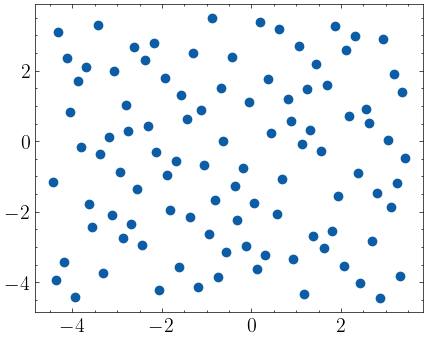

In [12]:
# plot beta grid
plt.figure(figsize=(5, 4))
plt.scatter(beta_grid_test[:, 0], beta_grid_test[:, 1])
plt.show()

In [13]:
# estimate cdf
x = np.linspace(-4.5, 3.5, 100)
y = np.linspace(-4.5, 3.5, 100)
X, Y = np.meshgrid(x, y)

Z_estimated = estimated_cdf_grid(X, Y, grid=beta_grid_test, thetas=theta_test)
Z_real = eval_gaussian_grid(X, Y, gaussian_means=means, gaussian_covs=sigmas, gaussian_mixing_coeff=mixing_probs)
mean_squared_error = np.mean((Z_real[:, :, 1]-Z_estimated)**2)
mean_squared_error

0.016502520970881788

In [14]:
def cross_validate(data_x: np.ndarray, data_y: np.ndarray,
                   mu_list: list, beta_grid: np.ndarray, kfold: int = 3,
                   compute_real_error: bool = False,
                   verbose=False):
    assert kfold >= 2
    if compute_real_error:
        xs = np.linspace(-4.5, 3.5, 1000)
        ys = np.linspace(-4.5, 3.5, 1000)
        x_grid, y_grid = np.meshgrid(xs, ys)
        real_cdf = eval_gaussian_grid(x_grid=x_grid, y_grid=y_grid,
                                      gaussian_means=means, gaussian_covs=sigmas, gaussian_mixing_coeff=mixing_probs)
        real_error = np.zeros((len(mu_list), kfold))

    cross_valid_error = np.zeros((len(mu_list), kfold))
    weights = np.zeros((len(mu_list), kfold, beta_grid.shape[0]))

    x_chunks = np.array_split(data_x, kfold)
    y_chunks = np.array_split(data_y, kfold)

    for mu_i in tqdm(range(len(mu_list)), desc='$\mu$', disable=not verbose):
        for k in range(kfold):
            test_data_chunk = np.concatenate((x_chunks[:k] + x_chunks[k+1:]), axis=0)
            test_product_chunk = np.concatenate((y_chunks[:k] + y_chunks[k+1:]), axis=0)

            theta_i_k, _ = solve_non_parametric(data_y=test_product_chunk, data_x=test_data_chunk,
                                                grid=beta_grid, mu_penalty=mu_list[mu_i])
            weights[mu_i, k] = theta_i_k

            # compute cross validation error
            tilde_z, tilde_y = eval_beta_grid(depended_y=y_chunks[k], explanatory_x=x_chunks[k],
                                              grid_vector=beta_grid)
            cross_valid_error[mu_i, k] = np.mean((tilde_z.dot(theta_i_k[:-1]) - tilde_y)**2)

            # compute error to true cdf
            if compute_real_error:
                estimate_cdf = estimated_cdf_grid(x_grid=x_grid, y_grid=y_grid,
                                                  grid=beta_grid, thetas=theta_i_k)
                real_error[mu_i, k] = np.mean((real_cdf[:, :, 1]-estimate_cdf)**2)
    if compute_real_error:
        return weights, cross_valid_error, real_error
    return weights, cross_valid_error

In [17]:
# list of mus for cross validation
mu_list_test = np.linspace(0, 50, 20)
k_folds = 2
print(mu_list_test)

[ 0.          2.63157895  5.26315789  7.89473684 10.52631579 13.15789474
 15.78947368 18.42105263 21.05263158 23.68421053 26.31578947 28.94736842
 31.57894737 34.21052632 36.84210526 39.47368421 42.10526316 44.73684211
 47.36842105 50.        ]


In [18]:
# create a function to use multiprocessing for the cross validation
def pool_wrapper(ind: int):
    w, c, e = cross_validate(data_x=products, data_y=choiceData,
                             mu_list=[mu_list_test[ind]],
                             beta_grid=beta_grid_test,
                             kfold=k_folds,
                             compute_real_error=True, verbose=False)
    return w, c, e

In [19]:
# create empty arrays for the results
error_true = np.zeros((len(mu_list_test), k_folds))
cross_validation_error = np.zeros((len(mu_list_test), k_folds))
weights_list = np.zeros((len(mu_list_test), k_folds, beta_grid_test.shape[0]))

# perform cross validation in parallel
with Pool() as pool:
    result = pool.map(pool_wrapper, range(len(mu_list_test)))

for r_i, res in enumerate(result):
    weights_list[r_i] = res[0]
    cross_validation_error[r_i] = res[1]
    error_true[r_i] = res[2]
print('Done!')

Done!


/Users/jonas.arruda/miniconda/envs/RandomCoefficients/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/jonas.arruda/miniconda/envs/RandomCoefficients/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/jonas.arruda/miniconda/envs/RandomCoefficients/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/jonas.arruda/miniconda/envs/RandomCoefficients/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to 

In [20]:
#weights_list, cross_validation_error, error_true = cross_validate(data_x=products, data_y=choiceData,
#                                                                  mu_list=mu_list_test,
#                                                                  beta_grid=beta_grid_test,
#                                                                  kfold=k_folds,
#                                                                  compute_real_error=True)

In [21]:
def compute_cv_mu(mu_list_test: np.ndarray, cross_validation_error: np.ndarray) -> (float, float):
    k_folds = cross_validation_error.shape[1]
    cross_valid_error_mean = np.mean(cross_validation_error, axis=1)
    mu_index = np.nanargmin(cross_valid_error_mean)
    mu_MSE = mu_list_test[mu_index]

    cvStandardError = np.std(cross_validation_error, axis=1) / np.sqrt(k_folds)
    allowed_mu = cross_valid_error_mean <= cross_valid_error_mean[mu_index] + cvStandardError[mu_index]
    muOneSe = np.max(mu_list_test[allowed_mu])
    return mu_MSE, muOneSe

In [22]:
mu_MSE, muOneSe = compute_cv_mu(mu_list_test, cross_validation_error)
print('best $\mu$ cross validated (MSE):', mu_MSE)
print('best $\mu$ cross validated (OneSE):', muOneSe)

true_error_mean = np.mean(error_true, axis=1)
best_mu = np.nanargmin(true_error_mean)

best $\mu$ cross validated (MSE): 0.0
best $\mu$ cross validated (OneSE): 28.947368421052634


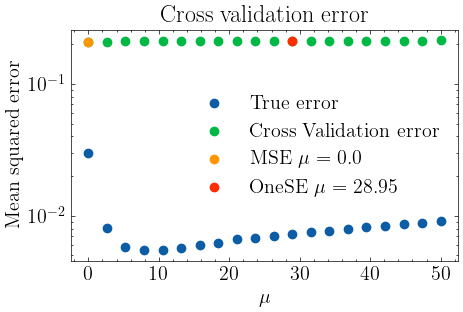

[0.20939233 0.20989592 0.21048314 0.21089933 0.21121597 0.21148815
 0.21167485 0.21187193 0.21205275 0.21225531 0.2124017  0.21256346
 0.2127229  0.21287507 0.2130239  0.21316867 0.2133069  0.21344582
 0.21358203 0.2137161 ]


In [23]:
cross_valid_error_mean = np.mean(cross_validation_error, axis=1)

plt.figure(figsize=(5, 3))
plt.scatter(mu_list_test, true_error_mean, label='True error')
plt.scatter(mu_list_test, cross_valid_error_mean, label='Cross Validation error')
plt.scatter(mu_list_test[np.nanargmin(cross_valid_error_mean)], np.nanmin(cross_valid_error_mean),
            label=f'MSE $\mu={mu_list_test[np.nanargmin(cross_valid_error_mean)].round(2)}$')
plt.scatter(muOneSe, cross_valid_error_mean[np.argmax(muOneSe == np.array(mu_list_test))],
            label=f'OneSE $\mu={muOneSe.round(2)}$')
plt.yscale('log')
plt.title('Cross validation error')
plt.xlabel('$\mu$')
plt.ylabel('Mean squared error')
plt.legend()
#plt.savefig('plots/cross_validation_error.pdf', bbox_inches='tight', dpi=600)
plt.show()

print(cross_valid_error_mean)

In [ ]:
n_weights = np.zeros(len(mu_list_test))
for mu_idx, mu in enumerate(mu_list_test):
    n_weights[mu_idx] = np.mean(np.sum(weights_list[mu_idx] > 1e-5, axis=1))

plt.figure(figsize=(5, 3))
plt.scatter(mu_list_test, n_weights)
plt.title('Number of weights')
plt.xlabel('$\mu$')
plt.ylabel('Number of weights')
#plt.savefig('plots/cross_validation_weights.pdf', bbox_inches='tight', dpi=600)
plt.show()

In [24]:
theta, beta_grid = solve_non_parametric(choiceData, products,
                                        grid=beta_grid_test,
                                        #n_grid_points=R,
                                        mu_penalty=muOneSe,
                                verbose=True)
Z_estimated = estimated_cdf_grid(X, Y, grid=beta_grid, thetas=theta)

28.947368432037592
     pcost       dcost       gap    pres   dres
 0: -4.2400e+00 -5.3331e+00  1e+02  1e+01  1e-16
 1: -4.2286e+00 -5.3000e+00  2e+00  9e-02  1e-16
 2: -4.2218e+00 -4.4782e+00  3e-01  1e-16  1e-16
 3: -4.2368e+00 -4.2969e+00  6e-02  2e-16  1e-16
 4: -4.2441e+00 -4.2496e+00  5e-03  4e-16  1e-16
 5: -4.2452e+00 -4.2455e+00  3e-04  5e-16  2e-16
 6: -4.2453e+00 -4.2453e+00  2e-05  8e-17  1e-16
 7: -4.2453e+00 -4.2453e+00  9e-07  1e-16  1e-16
Optimal solution found.
number of negative weights: 0
non-zero weights: 84
total number of weights: 100


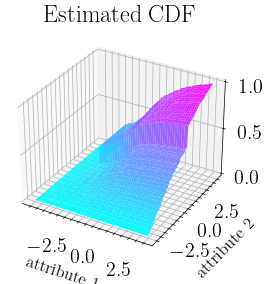

In [25]:
# plot cdf
plt.figure(figsize=(5, 3))
ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, Z_estimated, cmap='cool', label='estimated')

ax.set_title(f'Estimated CDF')# with error={np.mean((Z_real[:, :, 1]-Z_estimated)**2).round(5)}', fontsize=14)
ax.set_xlabel('attribute 1', fontsize=12)
ax.set_ylabel('attribute 2', fontsize=12)
ax.set_zlabel('z', fontsize=12)
#plt.savefig('plots/estimated_cdf.pdf', bbox_inches='tight', dpi=600)
plt.show()

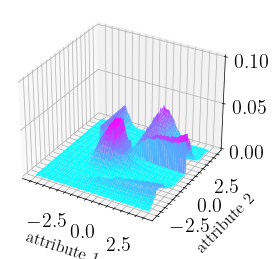

In [26]:
# plot difference cdf
plt.figure(figsize=(5,3))
ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, (Z_real[:, :, 1]-Z_estimated)**2, cmap='cool', label='cdf')

#ax.set_title('Squared Difference to True CDF', fontsize=14)
ax.set_xlabel('attribute 1', fontsize=12)
ax.set_ylabel('attribute 2', fontsize=12)
ax.set_zlabel('z', fontsize=12)
ax.set_zlim(0,0.1)

plt.show()

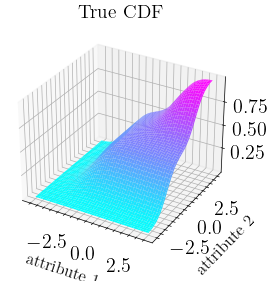

In [27]:
# plot cdf
plt.figure(figsize=(5, 3))
ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, Z_real[:, :, 1], cmap='cool', label='cdf')

ax.set_title('True CDF', fontsize=14)
ax.set_xlabel('attribute 1', fontsize=12)
ax.set_ylabel('attribute 2', fontsize=12)
ax.set_zlabel('z', fontsize=12)
#plt.savefig('plots/true_cdf.pdf', bbox_inches='tight', dpi=600)
plt.show()

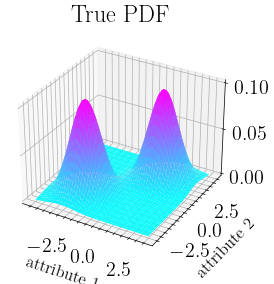

In [28]:
plt.figure(figsize=(5, 3))
ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, Z_real[:, :, 0], cmap='cool', label='pdf')

ax.set_title(f'True PDF')# with mean={means}', fontsize=14)
ax.set_xlabel('attribute 1', fontsize=12)
ax.set_ylabel('attribute 2', fontsize=12)
ax.set_zlabel('z', fontsize=12)
#plt.savefig('plots/true_pdf.pdf', bbox_inches='tight', dpi=600)
plt.show()

# compute pdf from cdf

In [ ]:
@njit
def estimated_cdf_pointwise(eval_point: np.ndarray, grid: np.ndarray, thetas: np.ndarray) -> float:
    cdf_out = 0
    for b_id, beta in enumerate(grid):
        if (eval_point > beta).all():
            cdf_out += thetas[b_id]
    return cdf_out

helper_cdf = partial(estimated_cdf_pointwise, grid=beta_grid, thetas=theta)

In [ ]:
def compute_pdf(x_grid, y_grid):
    assert x_grid.shape == y_grid.shape

    pdf = np.zeros((len(x_grid), len(y_grid)))
    hessian = nd.Hessian(helper_cdf)  # derivative in both directions needed

    for d1 in range(x_grid.shape[0]):
        for d2 in range(x_grid.shape[1]):
            h = hessian([x_grid[d1,d2], y_grid[d1,d2]])
            pdf[d1, d2] = h[0,1]
    return pdf

In [ ]:
%%time
pdf_estimate = compute_pdf(X, Y)

In [ ]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

#ax.plot_surface(X, Y, Z_real[:, :, 0], cmap='cool', label='pdf')
ax.plot_surface(X, Y, pdf_estimate, cmap='cool', label='pdf estimate')

ax.set_title(f'Estimated PDF', fontsize=14)
ax.set_xlabel('attribute 1', fontsize=12)
ax.set_ylabel('attribute 2', fontsize=12)
ax.set_zlabel('z', fontsize=12)

plt.show()

# Estimate Moments

In [29]:
def compute_moment(grid: np.ndarray, thetas: np.ndarray, n_moments: tuple):
    assert grid.shape[1] == len(n_moments), 'you must provide a tuple with as many entries as dimension of coefficients'

    grid_pow = np.power(grid, n_moments)
    moment = grid_pow.prod(axis=1).dot(thetas)
    return moment

In [30]:
pdf = lambda x0,x1: eval_gaussian_pdf([x0,x1], gaussian_means=means, gaussian_covs=sigmas, gaussian_mixing_coeff=mixing_probs)
ranges=[(-4.5, 3.5),(-4.5, 3.5)]
assert np.isclose(nquad(pdf,ranges=[(-10, 10),(-10, 10)])[0], 1), '0th moment should be 1'
nquad(pdf,ranges=ranges)[0]

0.9881181813734767

In [31]:
nquad(lambda x0: nquad(lambda x1: x0**2 * pdf(x0,x1), ranges=[(-4.5,3.5)])[0], ranges=[(-4.5,3.5)])[0], nquad(lambda x1: nquad(lambda x0: x1**2 * pdf(x0,x1), ranges=[(-4.5,3.5)])[0], ranges=[(-4.5,3.5)])[0]

(3.925326802002651, 3.925326802002651)

In [32]:
mean_from_pdf = np.array([nquad(lambda x0, x1: x0 * pdf(x0,x1), ranges=ranges)[0],
                          nquad(lambda x0, x1: x1 * pdf(x0,x1), ranges=ranges)[0]])
var_from_pdf = np.array([nquad(lambda x0, x1: x0**2 * pdf(x0,x1), ranges=ranges)[0],
                          nquad(lambda x0, x1: x1**2 * pdf(x0,x1), ranges=ranges)[0]]) - mean_from_pdf**2

In [33]:
assert np.isclose(compute_moment(beta_grid_test, theta_test, n_moments=(0, 0)), 1), '0th moment should be 1'

In [34]:
estimated_mean = np.array([compute_moment(beta_grid_test, theta_test, n_moments=(1, 0)),
                           compute_moment(beta_grid_test, theta_test, n_moments=(0, 1))])

estimated_var = np.array([compute_moment(beta_grid_test, theta_test, n_moments=(2, 0)),
                          compute_moment(beta_grid_test, theta_test, n_moments=(0, 2))]) - estimated_mean**2

In [35]:
real_sample_mean = np.mean(beta_unobserved, axis=0)
real_sample_var = np.var(beta_unobserved, axis=0)

In [36]:
print(estimated_mean, real_sample_mean, mean_from_pdf)
print(estimated_var, real_sample_var, var_from_pdf)

[-0.5415188  -0.51341911] [-0.41311149 -0.46694772] [-0.45033448 -0.45033448]
[1.45992478 2.5205167 ] [0.42840498 0.42060297] [3.72252566 3.72252566]


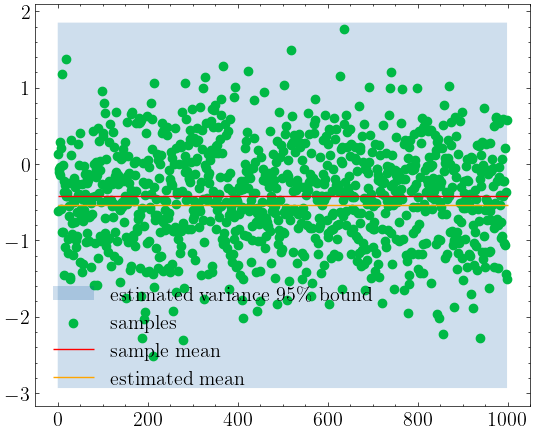

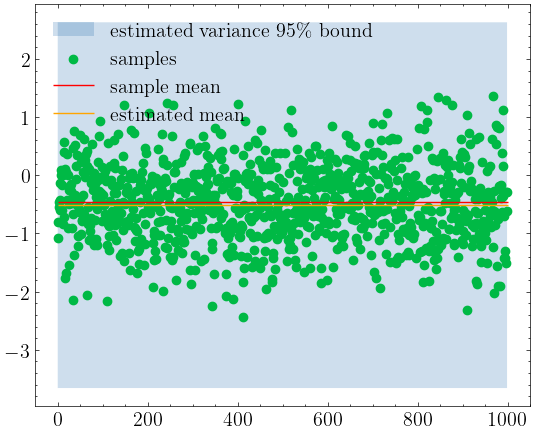

In [37]:
plt.figure(figsize=(6,5), tight_layout=True)

plt.fill_between(np.arange(beta_unobserved.shape[0]),
                estimated_mean[0]-1.98*np.sqrt(estimated_var[0]),  estimated_mean[0]+1.98*np.sqrt(estimated_var[0]),
                 alpha=0.2, label='estimated variance 95\% bound')

plt.scatter(x=np.arange(beta_unobserved.shape[0]), y=beta_unobserved[:, 0], label='samples')
plt.hlines(real_sample_mean[0], xmin=0, xmax=beta_unobserved.shape[0], color='red', label='sample mean')
plt.hlines(estimated_mean[0], xmin=0, xmax=beta_unobserved.shape[0], color='orange', label='estimated mean')

# plt fill between var 95% confidence interval
plt.legend()
plt.show()

plt.figure(figsize=(6,5), tight_layout=True)

plt.fill_between(np.arange(beta_unobserved.shape[0]),
                estimated_mean[1]-1.98*np.sqrt(estimated_var[1]),  estimated_mean[1]+1.98*np.sqrt(estimated_var[1]),
                 alpha=0.2, label='estimated variance 95\% bound')

plt.scatter(x=np.arange(beta_unobserved.shape[0]), y=beta_unobserved[:, 1], label='samples')
plt.hlines(real_sample_mean[1], xmin=0, xmax=beta_unobserved.shape[0], color='red', label='sample mean')
plt.hlines(estimated_mean[1], xmin=0, xmax=beta_unobserved.shape[0], color='orange', label='estimated mean')
plt.legend()
plt.show()

# Test Sampling Methods

In [40]:
beta_grid_test_uniform = make_beta_grid(n_grid_points=128, dim=products.shape[2], support=(-4.5, 3.5),
                                        sampling_type='uniform')
beta_grid_test_latin = make_beta_grid(n_grid_points=128, dim=products.shape[2], support=(-4.5, 3.5),
                                        sampling_type='latin_hypercubes')
beta_grid_test_latin_2 = make_beta_grid(n_grid_points=121, dim=products.shape[2], support=(-4.5, 3.5),
                                        sampling_type='latin_hypercubes_2')
beta_grid_test_sobol = make_beta_grid(n_grid_points=128, dim=products.shape[2], support=(-4.5, 3.5),
                                        sampling_type='sobol')
beta_grid_test_halton = make_beta_grid(n_grid_points=128, dim=products.shape[2], support=(-4.5, 3.5),
                                        sampling_type='halton')
x = np.linspace(-4.5, 3.5, 11)
y = np.linspace(-4.5, 3.5, 11)
beta_grid_test_equi = np.concatenate([np.array([np.ones_like(y)*x_i, y]) for x_i in x], axis=1).T

In [41]:
uniform, latin, latin_2, sobol, halton = [], [], [], [], []
for i in range(1000):
    uniform_grid = make_beta_grid(n_grid_points=128, dim=products.shape[2], support=(0, 1),
                                            sampling_type='uniform')
    uniform.append(scipy.stats.qmc.discrepancy(uniform_grid, method='MD'))
    latin_grid = make_beta_grid(n_grid_points=128, dim=products.shape[2], support=(-0, 1),
                                            sampling_type='latin_hypercubes')
    latin.append(scipy.stats.qmc.discrepancy(latin_grid, method='MD'))
    latin_2_grid = make_beta_grid(n_grid_points=121, dim=products.shape[2], support=(0, 1),
                                            sampling_type='latin_hypercubes_2')
    latin_2.append(scipy.stats.qmc.discrepancy(latin_2_grid, method='MD'))
    sobol_grid = make_beta_grid(n_grid_points=128, dim=products.shape[2], support=(0, 1),
                                            sampling_type='sobol')
    sobol.append(scipy.stats.qmc.discrepancy(sobol_grid, method='MD'))
    halton_grid = make_beta_grid(n_grid_points=128, dim=products.shape[2], support=(0, 1),
                                            sampling_type='halton')
    halton.append(scipy.stats.qmc.discrepancy(halton_grid, method='MD'))

print('uniform', np.mean(uniform).round(6))
print('latin', np.mean(latin).round(6))
print('latin_2', np.mean(latin_2).round(6))
print('sobol', np.mean(sobol).round(6))
print('halton', np.mean(halton).round(6))

x_01 = np.linspace(0, 1, 11)
y_01 = np.linspace(0, 1, 11)
equi_grid = np.concatenate([np.array([np.ones_like(y_01)*x_i, y_01]) for x_i in x_01], axis=1).T
print('equi', np.round(scipy.stats.qmc.discrepancy(equi_grid, method='MD'), 6))

uniform 0.004431
latin 0.000266
latin_2 0.0001
sobol 8.1e-05
halton 0.000124
equi 0.007307


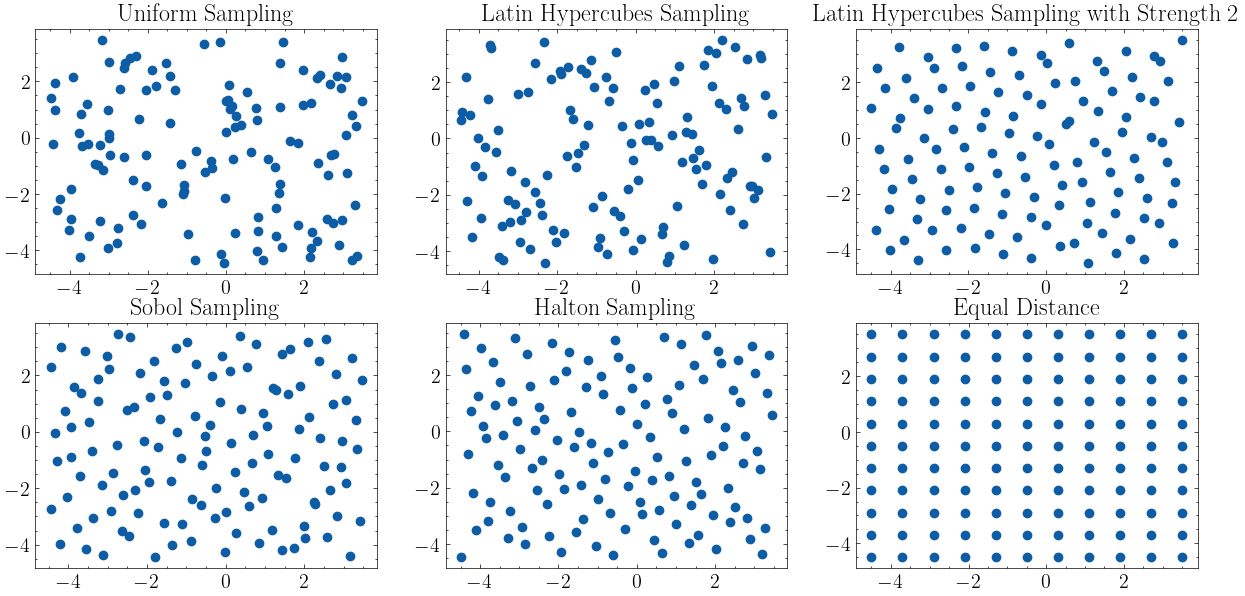

In [42]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))

ax[0,0].set_title('Uniform Sampling')
ax[0,0].scatter(beta_grid_test_uniform[:, 0], beta_grid_test_uniform[:, 1])

ax[0,1].set_title('Latin Hypercubes Sampling')
ax[0,1].scatter(beta_grid_test_latin[:, 0], beta_grid_test_latin[:, 1])

ax[0,2].set_title('Latin Hypercubes Sampling with Strength 2')
ax[0,2].scatter(beta_grid_test_latin_2[:, 0], beta_grid_test_latin_2[:, 1])

ax[1,0].set_title('Sobol Sampling')
ax[1,0].scatter(beta_grid_test_sobol[:, 0], beta_grid_test_sobol[:, 1])

ax[1,1].set_title('Halton Sampling')
ax[1,1].scatter(beta_grid_test_halton[:, 0], beta_grid_test_halton[:, 1])

ax[1,2].set_title('Equal Distance')
ax[1,2].scatter(beta_grid_test_equi[:, 0], beta_grid_test_equi[:, 1])

#plt.savefig('plots/sampling_methods.pdf', bbox_inches='tight', dpi=600)
plt.show()

# Monte Carlo Simulations with fixed list of $\mu$'s

In [ ]:
method_list = ['uniform', 'latin_hypercubes', 'latin_hypercubes_2', 'sobol', 'halton']
n_grid_points_list = np.array([128, 128, 121, 128, 128])  # latin_hypercubes_2 needs number = prime number**2
mu_list = [0, 10, 25, 50, 75, 100]
use_random_eval_grids = False
n_grid_points_eval = 10000
prior_support = (-4.5, 3.5)
n_iterations = 100
n_individuals_mc = 1000

if not use_random_eval_grids:
    # use fixed grid
    x = np.linspace(prior_support[0], prior_support[1], int(np.ceil(np.sqrt(n_grid_points_eval))))
    y = np.linspace(prior_support[0], prior_support[1], int(np.ceil(np.sqrt(n_grid_points_eval))))
    X, Y = np.meshgrid(x, y)
    Z_real = eval_gaussian_grid(X, Y, gaussian_means=means, gaussian_covs=sigmas, gaussian_mixing_coeff=mixing_probs)

error_mc = np.zeros((len(method_list), len(mu_list), n_iterations))
moments_1_mc = np.zeros((len(method_list), len(mu_list), n_iterations, products.shape[1]))
moments_2_mc = np.zeros((len(method_list), len(mu_list), n_iterations, products.shape[1]))
error_moments_1_mc = np.zeros((len(method_list), len(mu_list), n_iterations, products.shape[1]))
error_moments_2_mc = np.zeros((len(method_list), len(mu_list), n_iterations, products.shape[1]))
for i in tqdm(range(n_iterations), desc='Computing Errors'):
    # create new data
    mc_products, beta_unobserved, mc_choiceData = generate_data(gaussian_means=means,
                                                                gaussian_sigmas=sigmas,
                                                                gaussian_mixing_probs=mixing_probs,
                                                                n_consumers=n_individuals_mc,
                                                                seed=i)
    real_sample_mean = np.mean(beta_unobserved, axis=0)
    real_sample_var = np.var(beta_unobserved, axis=0)

    # eval grid
    if use_random_eval_grids:
        xy = make_beta_grid(n_grid_points=n_grid_points_eval,
                            dim=mc_products.shape[2],
                            support=prior_support,
                            sampling_type='uniform')
        Z_real = eval_gaussian_vector(xy, gaussian_means=means, gaussian_covs=sigmas, gaussian_mixing_coeff=mixing_probs)

    for method_i, method in enumerate(method_list):
        beta_grid_test = make_beta_grid(n_grid_points=n_grid_points_list[method_i],
                                        dim=mc_products.shape[2],
                                        support=prior_support,
                                        sampling_type=method)

        for mu_i, mu_penalty in enumerate(mu_list):
            theta_test, _ = solve_non_parametric(data_y=mc_choiceData,
                                                 data_x=mc_products,
                                                 grid=beta_grid_test,
                                                 mu_penalty=mu_penalty,
                                                 verbose=False)
            # compute mean squared error to true cdf
            if use_random_eval_grids:
                Z_estimated = estimated_cdf_vector(xy, grid=beta_grid_test, thetas=theta_test)
                error_mc[method_i, mu_i, i]  = np.mean((Z_real-Z_estimated)**2)
            else:
                Z_estimated = estimated_cdf_grid(X, Y, grid=beta_grid_test, thetas=theta_test)
                error_mc[method_i, mu_i, i]  = np.mean((Z_real[:, :, 1]-Z_estimated)**2)

            # compute error in moments
            moments_1_mc[method_i, mu_i, i] = np.array([compute_moment(beta_grid_test, theta_test, n_moments=(1, 0)),
                                                        compute_moment(beta_grid_test, theta_test, n_moments=(0, 1))])

            moments_2_mc[method_i, mu_i, i] = np.array([compute_moment(beta_grid_test, theta_test, n_moments=(2, 0)),
                                                        compute_moment(beta_grid_test, theta_test, n_moments=(0, 2))])
            moments_2_mc[method_i, mu_i, i] -= moments_1_mc[method_i, mu_i, i]**2

            # mean over different product dimensions
            error_moments_1_mc[method_i, mu_i, i] = (moments_1_mc[method_i, mu_i, i] - real_sample_mean)**2
            error_moments_2_mc[method_i, mu_i, i] = moments_2_mc[method_i, mu_i, i]/real_sample_var

In [ ]:
print('error to true cdf')
fig, ax = plt.subplots(1, len(mu_list), figsize=(12, 3), sharey='all', sharex='all', tight_layout=True)

for mu_i in range(len(mu_list)):
    ax[mu_i].boxplot(error_mc[:, mu_i, :].T, labels=method_list, vert=False)
    ax[mu_i].set_title(f'$\mu={mu_list[mu_i]}$')
#plt.xscale('log')
#plt.savefig('plots/sampling_methods_variance.pdf', bbox_inches='tight', dpi=600)
plt.show()

In [ ]:
print('$\mu=0$', scipy.stats.levene(error_mc[0, 0], error_mc[1, 0], error_mc[2, 0], error_mc[3, 0], error_mc[4, 0]))
print('$\mu=10$', scipy.stats.levene(error_mc[0, 1], error_mc[1, 1], error_mc[2, 1], error_mc[3, 1], error_mc[4, 1]))
print('$\mu=25$', scipy.stats.levene(error_mc[0, 2], error_mc[1, 2], error_mc[2, 2], error_mc[3, 2], error_mc[4, 2]))
print('$\mu=50$', scipy.stats.levene(error_mc[0, 3], error_mc[1, 3], error_mc[2, 3], error_mc[3, 3], error_mc[4, 3]))
print('$\mu=75$', scipy.stats.levene(error_mc[0, 4], error_mc[1, 4], error_mc[2, 4], error_mc[3, 4], error_mc[4, 4]))
print('$\mu=100$', scipy.stats.levene(error_mc[0, 5], error_mc[1, 5], error_mc[2, 5], error_mc[3, 5], error_mc[4, 5]))

In [ ]:
# take mean over product attributes
error_moments_1_mc_mean = np.mean(error_moments_1_mc, axis=3)
error_moments_2_mc_mean = np.mean(error_moments_2_mc, axis=3)

In [ ]:
print('squared difference in mean')
fig, ax = plt.subplots(1, len(mu_list), figsize=(10, 3), sharey='all', sharex='all', tight_layout=True)
for mu_i in range(len(mu_list)):
    ax[mu_i].boxplot(error_moments_1_mc_mean[:, mu_i, :].T, labels=method_list, vert=False)
    ax[mu_i].set_title(f'$\mu={mu_list[mu_i]}$')
#plt.xscale('log')
plt.show()

print('relative estimated variance')
fig, ax = plt.subplots(1, len(mu_list), figsize=(10, 3), sharey='all', sharex='all', tight_layout=True)
for mu_i in range(len(mu_list)):
    ax[mu_i].boxplot(error_moments_2_mc_mean[:, mu_i, :].T, labels=method_list, vert=False)
    ax[mu_i].set_title(f'$\mu={mu_list[mu_i]}$')
#plt.xscale('log')
plt.show()

In [ ]:
# take median over iterations of monte carlo simulation
for i, rel_err_var in enumerate(np.median(error_moments_2_mc_mean, axis=2)):
    plt.plot(mu_list, rel_err_var, label=method_list[i])
    #plt.plot(mu_list, (rel_err_var-7)/4, label=method_list[i])
plt.xlabel("$\mu$")
plt.ylabel("Median of Relative Error of Variance")
#plt.xscale('log')
plt.legend()
plt.show()

# Monte Carlo Simulations with Cross Validation

In [ ]:
# comparing methods
#method_list = ['uniform', 'latin_hypercubes', 'latin_hypercubes_2', 'sobol', 'halton']
#n_grid_points_list = np.array([128, 128, 121, 128, 128])  # latin_hypercubes_2 needs number = prime number**2

# comparing number of grid points
method_list = ['halton', 'halton', 'halton', 'halton', 'halton', 'halton', 'halton']
n_grid_points_list = np.array([10, 50, 100, 200, 250, 500, 1000])  # latin_hypercubes_2 needs number = prime number**2
names = [f'{n_g}' for m, n_g in zip(method_list, n_grid_points_list)]


use_random_eval_grids = False
n_grid_points_eval = 10000
prior_support = (-4.5, 3.5)
n_iterations = 100
k_folds = 2
n_individuals_mc = 1000

if not use_random_eval_grids:
    # use fixed grid
    x = np.linspace(prior_support[0], prior_support[1], int(np.ceil(np.sqrt(n_grid_points_eval))))
    y = np.linspace(prior_support[0], prior_support[1], int(np.ceil(np.sqrt(n_grid_points_eval))))
    X, Y = np.meshgrid(x, y)
    Z_real = eval_gaussian_grid(X, Y, gaussian_means=means, gaussian_covs=sigmas, gaussian_mixing_coeff=mixing_probs)

error_mc = np.zeros((len(method_list), 3, n_iterations))
moments_1_mc = np.zeros((len(method_list), 3, n_iterations, products.shape[1]))
moments_2_mc = np.zeros((len(method_list), 3, n_iterations, products.shape[1]))
error_moments_1_mc = np.zeros((len(method_list), 3, n_iterations, products.shape[1]))
error_moments_2_mc = np.zeros((len(method_list), 3, n_iterations, products.shape[1]))
list_mu_MSE = np.zeros((len(method_list), n_iterations))
list_mu_OneSE = np.zeros((len(method_list), n_iterations))
for i in tqdm(range(n_iterations), desc='Computing Errors'):
    # create new data
    mc_products, beta_unobserved, mc_choiceData = generate_data(gaussian_means=means,
                                                                gaussian_sigmas=sigmas,
                                                                gaussian_mixing_probs=mixing_probs,
                                                                n_consumers=n_individuals_mc,
                                                                seed=i)
    real_sample_mean = np.mean(beta_unobserved, axis=0)
    real_sample_var = np.var(beta_unobserved, axis=0)

    # create random mu for cross validation, using halton sequence to get more or less equidistant points
    mu_list_cv_test = make_beta_grid(n_grid_points=18,
                            dim=1,
                            support=(0,50),
                            sampling_type='halton').flatten()
    mu_list_cv_test = np.append(mu_list_cv_test, [0,50])
    mu_list_cv_test.sort()

    # eval grid
    if use_random_eval_grids:
        xy = make_beta_grid(n_grid_points=n_grid_points_eval,
                            dim=mc_products.shape[2],
                            support=prior_support,
                            sampling_type='uniform')
        Z_real = eval_gaussian_vector(xy, gaussian_means=means, gaussian_covs=sigmas, gaussian_mixing_coeff=mixing_probs)

    for method_i, method in enumerate(method_list):
        beta_grid_test = make_beta_grid(n_grid_points=n_grid_points_list[method_i],
                                        dim=mc_products.shape[2],
                                        support=prior_support,
                                        sampling_type=method)
        # perform cross validation in parallel
        def pool_wrapper(ind: int):
            w, c = cross_validate(data_x=mc_products, data_y=mc_choiceData,
                                     mu_list=[mu_list_cv_test[ind]],
                                     beta_grid=beta_grid_test,
                                     kfold=k_folds,
                                     compute_real_error=False, verbose=False)
            return w, c
        cross_validation_error = np.zeros((len(mu_list_cv_test), k_folds))
        weights_list = np.zeros((len(mu_list_cv_test), k_folds, beta_grid_test.shape[0]))

        with Pool() as pool:
            result = pool.map(pool_wrapper, range(len(mu_list_cv_test)))

        for r_i, res in enumerate(result):
            weights_list[r_i] = res[0]
            cross_validation_error[r_i] = res[1]

        mu_MSE, mu_OneSe = compute_cv_mu(mu_list_cv_test, cross_validation_error)
        list_mu_MSE[method_i, i] = mu_MSE
        list_mu_OneSE[method_i, i] = mu_OneSe

        for mu_i, mu_penalty in enumerate([0, mu_MSE, mu_OneSe]):
            theta_test, _ = solve_non_parametric(data_y=mc_choiceData,
                                                 data_x=mc_products,
                                                 grid=beta_grid_test,
                                                 mu_penalty=mu_penalty,
                                                 verbose=False)
            # compute mean squared error to true cdf
            if use_random_eval_grids:
                Z_estimated = estimated_cdf_vector(xy, grid=beta_grid_test, thetas=theta_test)
                error_mc[method_i, mu_i, i]  = np.mean((Z_real-Z_estimated)**2)
            else:
                Z_estimated = estimated_cdf_grid(X, Y, grid=beta_grid_test, thetas=theta_test)
                error_mc[method_i, mu_i, i]  = np.mean((Z_real[:, :, 1]-Z_estimated)**2)

            # compute error in moments
            moments_1_mc[method_i, mu_i, i] = np.array([compute_moment(beta_grid_test, theta_test, n_moments=(1, 0)),
                                                        compute_moment(beta_grid_test, theta_test, n_moments=(0, 1))])

            moments_2_mc[method_i, mu_i, i] = np.array([compute_moment(beta_grid_test, theta_test, n_moments=(2, 0)),
                                                        compute_moment(beta_grid_test, theta_test, n_moments=(0, 2))])
            moments_2_mc[method_i, mu_i, i] -= moments_1_mc[method_i, mu_i, i]**2

            # mean over different product dimensions
            error_moments_1_mc[method_i, mu_i, i] = (moments_1_mc[method_i, mu_i, i] - real_sample_mean)**2
            error_moments_2_mc[method_i, mu_i, i] = moments_2_mc[method_i, mu_i, i]/real_sample_var

In [ ]:
mu_name = ['$\mu=0$', '$\mu_{MSE}$', '$\mu_{OneSE}$']

In [ ]:
print('error to true cdf')
fig, ax = plt.subplots(1, len(mu_name), figsize=(10, 3), sharey='all', sharex='all', tight_layout=True)

for mu_i in range(len(mu_name)):
    ax[mu_i].boxplot(error_mc[:, mu_i, :].T,
                     labels=names,#method_list,
                     vert=False)
    ax[mu_i].set_title(f'{mu_name[mu_i]}')
ax[0].set_ylabel('Number of Grid Points')
ax[1].set_xlabel('Mean Squared Error')
plt.savefig('plots/error_grid_points.pdf', bbox_inches='tight', dpi=600)
#plt.savefig('plots/sampling_methods_error.pdf', bbox_inches='tight', dpi=600)
plt.show()

In [ ]:
# testing for difference in mean
print('Halton-Sobol:', scipy.stats.ttest_ind(error_mc[0, -1, :], error_mc[1, -1, :], equal_var = False))
print('Halton-Latin:', scipy.stats.ttest_ind(error_mc[0, -1, :], error_mc[2, -1, :], equal_var = False))
print('Halton-Latin2:', scipy.stats.ttest_ind(error_mc[0, -1, :], error_mc[3, -1, :], equal_var = False))
print('Halton-Uniform:', scipy.stats.ttest_ind(error_mc[0, -1, :], error_mc[4, -1, :], equal_var = False))

In [ ]:
error_moments_1_mc_mean = np.mean(error_moments_1_mc, axis=3)
error_moments_2_mc_mean = np.mean(error_moments_2_mc, axis=3)

In [ ]:
print('squared difference in mean')
fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharey='all', sharex='all', tight_layout=True)
for mu_i in range(len(mu_name)):
    ax[mu_i].boxplot(error_moments_1_mc_mean[:, mu_i, :].T, labels=method_list, vert=False)
    ax[mu_i].set_title(f'{mu_name[mu_i]}')
#plt.savefig('plots/sampling_methods_moments2.pdf', bbox_inches='tight', dpi=600)
plt.show()

print('relative estimated variance')
fig, ax = plt.subplots(1, len(mu_name), figsize=(10, 3), sharey='all', sharex='all', tight_layout=True)
for mu_i in range(len(mu_name)):
    ax[mu_i].boxplot(error_moments_2_mc_mean[:, mu_i, :].T, labels=method_list, vert=False)
    ax[mu_i].set_title(f'{mu_name[mu_i]}')
#plt.savefig('plots/sampling_methods_moments2.pdf', bbox_inches='tight', dpi=600)
plt.show()

In [ ]:
print('different choices of $\mu$ of cross-validation')
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey='all', sharex='all', tight_layout=True)

ax[0].boxplot(list_mu_MSE.T, labels=method_list, vert=False)
ax[0].set_title(f'{mu_name[1]}')
ax[1].boxplot(list_mu_OneSE.T, labels=method_list, vert=False)
ax[1].set_title(f'{mu_name[2]}')
#plt.savefig('plots/sampling_methods_choice.pdf', bbox_inches='tight', dpi=600)
plt.show()